<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Pedro Lucas Barrera - a1801

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer, text_to_word_sequence
from keras.layers import Input
from keras.utils import plot_model


In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /Users/pedrobarrera/procesamiento_lenguaje_natural/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 16.6MB/s]


In [5]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [6]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [7]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [22]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

Decido usar un tokenizer distinto para input y output dado que output posee "sos" y "eos".

In [27]:
#Por el limite de recursos, en caso de que sean muchas
MAX_VOCAB_SIZE = 8000

In [28]:
# Crear tokenizers
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Fit en los datos
input_tokenizer.fit_on_texts(input_sentences)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] +output_sentences)

input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [29]:
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de input:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario de input: 1799
Sentencia de entrada más larga: 9


In [30]:
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de output:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario de output: 1806
Sentencia de salida más larga: 10


In [33]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [34]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 1807)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [49]:
# Para descargar los embeddings de fasttext se consigui el codigo usando ia generativa, con el siguiente prompt:
# Dame un codigo simple para descargar los embeddings 'cc.en.300.vec' FastText
import os

# Verificar si ya existe
if os.path.exists('cc.en.300.vec'):
    print("✅ Embeddings ya descargados")
else:
    print("Descargando FastText embeddings (1.6 GB)...")
    print("Esto puede tomar 5-15 minutos...")
    
    # Descargar con curl (el más confiable)
    !curl -L -o cc.en.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
    
    # Descomprimir
    !gunzip cc.en.300.vec.gz
    
    print("✅ Descarga completada!")

# Verificar que funciona
if os.path.exists('cc.en.300.vec'):
    with open('cc.en.300.vec', 'r') as f:
        first_line = f.readline().strip()
        print(f"Archivo listo: {first_line}")

Descargando FastText embeddings (1.6 GB)...
Esto puede tomar 5-15 minutos...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1264M  100 1264M    0     0  21.0M      0  0:01:00  0:01:00 --:--:-- 21.4M
✅ Descarga completada!
Archivo listo: 2000000 300


In [50]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [51]:
model_embeddings = FasttextEmbeddings()

In [64]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [65]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/Users/pedrobarrera/procesamiento_lenguaje_natural/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 9, 300)    │    540,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 10, 128)   │    231,296 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_3[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_4[0][0… │
│                     │ (None, 128),      │            │ lstm_3[0][1],     │
│                     │ (None, 128)]      │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 1807)  │    233,103 │ lstm_4[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,355,631 (5.17 MB)

 Trainable params: 815,631 (3.11 MB)

 Non-trainable params: 540,000 (2.06 MB)

In [66]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [67]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [68]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [69]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=40, 
    validation_split=0.2)

Epoch 1/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5434 - loss: 2.9260 - val_accuracy: 0.6322 - val_loss: 2.2462
Epoch 2/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6293 - loss: 2.0406 - val_accuracy: 0.6661 - val_loss: 2.0604
Epoch 3/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6841 - loss: 1.7981 - val_accuracy: 0.6862 - val_loss: 1.9154
Epoch 4/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7109 - loss: 1.6418 - val_accuracy: 0.7005 - val_loss: 1.8323
Epoch 5/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7235 - loss: 1.5397 - val_accuracy: 0.7073 - val_loss: 1.7838
Epoch 6/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7310 - loss: 1.4687 - val_accuracy: 0.7122 - val_loss: 1.7482
Epoch 7/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7377 - loss: 1.4137 - val_accuracy: 0.7141 - val_loss: 1.7209
Epoch 8/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7407 - loss: 1.3684 - val_accu

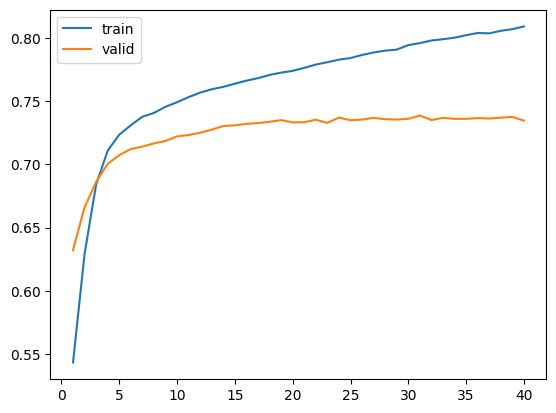

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [71]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [82]:
# Verificar qué tokens tienes en el vocabulario
print("Tokens especiales en word2idx_outputs:")
special_tokens = ['<sos>', '<eos>', 'sos', 'eos']
for token in special_tokens:
    if token in word2idx_outputs:
        print(f"✅ '{token}': {word2idx_outputs[token]}")
    else:
        print(f"❌ '{token}': No encontrado")

print(f"\nPrimeras 10 palabras en vocabulario: {list(word2idx_outputs.keys())[:10]}")

Tokens especiales en word2idx_outputs:
❌ '<sos>': No encontrado
❌ '<eos>': No encontrado
✅ 'sos': 815
✅ 'eos': 1

Primeras 10 palabras en vocabulario: ['eos', 'you', 'i', 'do', 'what', 'a', 'are', 'to', 'for', 'how']


Parece que por el normalizado o tokenizado, se eliminaron erroneamente los caracteres <>. Por esto tomaremos como principio y final de frase los placeholders sos y eso sin los <>. la siguiente funcion genera una respuesta del chatbot dada una secuencia de entrada

In [87]:
def chat_response(input_text):

    # Preprocess the input text (same as training data)
    input_text_clean = clean_text(input_text)
    
    # Convert to sequence
    input_seq = input_tokenizer.texts_to_sequences([input_text_clean])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len)
    
    # Get encoder states
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Initialize decoder input with "sos"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['sos']

    # Get the end token index
    eos = word2idx_outputs['eos']
    
    response_words = []
    for _ in range(max_out_len):
        # Predict next token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        predicted_idx = np.argmax(output_tokens[0, 0, :])

        # Stop if we hit end of sentence
        if eos == predicted_idx:
            break

        # Convert index to word
        if predicted_idx > 0:
            word = idx2word_target[predicted_idx]
            response_words.append(word)

        # Update states for next prediction
        states_value = [h, c]
        
        # Update decoder input
        target_seq[0, 0] = predicted_idx

    return ' '.join(response_words)

Testeo el chatbot con frases de ejemplo recomendadas y otras agregadas

In [88]:
def test_chatbot():

    test_questions = [
        "Do you read?",
        "Do you have any pet?", 
        "Where are you from?",
        "Hi how are you?",
        "What do you like to do?",
        "Whats your name?",
        "Are you ok?"
    ]
    
    print("Test:")
    print("----------------------------------")
    
    for question in test_questions:
        response = chat_response(question)
        print(f"User: {question}")
        print(f"Bot:  {response}")
        print("----------------------------------")

# Run the test
test_chatbot()

Test:
----------------------------------
User: Do you read?
Bot:  i like to go to the beach
----------------------------------
User: Do you have any pet?
Bot:  i like to go to the beach
----------------------------------
User: Where are you from?
Bot:  i am a vegan i am a vegan
----------------------------------
User: Hi how are you?
Bot:  i am fine and you
----------------------------------
User: What do you like to do?
Bot:  i like to go to the beach
----------------------------------
User: Whats your name?
Bot:  i am a student
----------------------------------
User: Are you ok?
Bot:  i am a student
----------------------------------


### 6 - Conclusion

La salida es repetitiva en muchos casos y repite frases como 'I am vegan', 'i like to go to the beach', o 'i am a student' lo que indica que el modelo no esta funcionando bien, dado que genera respuestas repetitivas y sin sentido. Esto es extraño dado que en el entrenamiento se habian alcanzado accuracies de validacion del 75% y de train del 80%. Podria deberse a una falta de datos que haga que el set entrenamiento no sea lo suficientemente representativo. 